In [1]:
import psycopg2
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
from plotly.offline import plot 
import plotly.graph_objects as go
import warnings
import datetime
warnings.filterwarnings('ignore')

# import q_credentials.db_secmaster_cloud_cred as db_secmaster_cred
import q_credentials.db_secmaster_cred as db_secmaster_cred
import q_credentials.db_indicator_cred as db_indicator_cred


In [2]:
# connect to our securities_master database
conn_secmaster = psycopg2.connect(host=db_secmaster_cred.dbHost , database=db_secmaster_cred.dbName, user=db_secmaster_cred.dbUser, password=db_secmaster_cred.dbPWD)
conn_indicator = psycopg2.connect(host=db_indicator_cred.dbHost , database=db_indicator_cred.dbName, user=db_indicator_cred.dbUser, password=db_indicator_cred.dbPWD)
# df_ticker_last_day=pd.read_sql(sql,con=conn_secmaster)

In [3]:
# sql="""SELECT s.ticker, count(d.stock_id), max(d.date_price) as last_date, min(d.date_price) as start_date
# FROM public.symbol s inner join daily_data d on s.id= d.stock_id
# group by s.ticker"""
# df_ticker_last_day=pd.read_sql(sql,con=conn_secmaster)

In [4]:
sql="""select s.ticker, min(date_price),max(date_price) from daily_data d join symbol s on d.symbol_id=s.id group by s.ticker"""
ind_tickers=list(pd.read_sql(sql,con=conn_indicator)['ticker'])

In [5]:
start_date=datetime.datetime(2018,1,1).strftime("%Y-%m-%d")
ind_name='candle_2'

In [6]:
# sql="select d.date_price as Timestamp,s.ticker as Ticker, d.value from daily_data d join symbol s on d.symbol_id = s.id join indicator i on i.id=d.indicator_id where s.ticker in ('%s') and i.name = '%s' and d.date_price > '%s'" %("','".join(ind_tickers), ind_name, start_date)
# df_indicator=pd.read_sql(sql,con=conn_indicator)

In [7]:
# df_indicator['ticker'].unique()

In [27]:
sql="select d.date_price as date,s.ticker as asset, d.value from daily_data d join symbol s on d.symbol_id = s.id join indicator i on i.id=d.indicator_id where s.ticker in ('%s') and i.name = '%s' and d.date_price > '%s'" %("','".join(ind_tickers), ind_name, start_date)
df_indicator=pd.read_sql(sql,con=conn_indicator)
df_indicator['date']=pd.to_datetime(df_indicator['date'])
df_indicator=pd.concat([df_indicator.drop(['value'], axis=1), df_indicator['value'].apply(pd.Series)], axis=1)
df_indicator=df_indicator[df_indicator['level'].isin([-2,-1,0,1,2])]
df_indicator=df_indicator.reset_index(drop=True).set_index(['date','asset'])
df_indicator=df_indicator[['level']]
df_indicator.head()

,,level
date,asset,
2018-01-02,NAVI,0.0
2018-01-03,NAVI,0.0
2018-01-04,NAVI,0.0
2018-01-05,NAVI,0.0
2018-01-08,NAVI,0.0


In [28]:
df_indicator = df_indicator.unstack()
df_indicator.index=df_indicator.index.tz_localize('UTC')
df_indicator.head()

level                                        
asset                        ES   FB   LB  LKQ MDLZ MNST NAVI  PSX TRIP
date                                                                   
2018-01-02 00:00:00+00:00  -2.0  0.0  0.0  0.0  0.0 -1.0  0.0  2.0  0.0
2018-01-03 00:00:00+00:00   0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0
2018-01-04 00:00:00+00:00   0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN -1.0
2018-01-05 00:00:00+00:00   2.0  0.0  NaN  0.0  0.0  NaN  0.0  2.0  NaN
2018-01-08 00:00:00+00:00   1.0  0.0  0.0  0.0 -2.0  1.0  0.0  0.0  0.0

In [29]:
sql="select d.date_price as date, s.ticker, open_price as open, high_price as high, low_price as low , close_price as close,volume from daily_data d join symbol s on d.stock_id = s.id where s.ticker in ('%s') and d.date_price > '%s'" %("','".join(ind_tickers), start_date)
df_price=pd.read_sql(sql,con=conn_secmaster)
df_price=df_price.pivot(index='date',columns='ticker',values='close')
df_price.index=df_price.index.tz_localize('UTC')

In [30]:
df_price.head()

ticker,ES,FB,LB,LKQ,MDLZ,MNST,NAVI,PSX,TRIP
date,,,,,,,,,
2018-01-02 00:00:00+00:00,63.15,181.42,59.89,41.35,42.41,62.71,13.63,101.75,34.77
2018-01-03 00:00:00+00:00,62.59,184.67,58.16,41.56,42.58,63.12,13.78,102.43,34.97
2018-01-04 00:00:00+00:00,61.71,184.33,51.00,42.06,42.68,63.36,13.94,102.15,34.92
2018-01-05 00:00:00+00:00,61.82,186.85,50.36,42.02,43.23,63.49,14.01,102.16,34.73
2018-01-08 00:00:00+00:00,62.25,188.28,48.64,41.86,43.01,64.03,13.69,102.06,34.67


In [31]:
common_indexes = set(df_indicator.index).intersection(set(df_price.index))

In [32]:
df_indicator=df_indicator.loc[common_indexes,:]
df_indicator.sort_index(inplace=True)
df_indicator=df_indicator.stack()
df_indicator.columns=[""]
df_indicator=df_indicator.rank(method='first')
df_indicator.head()

date                      asset       
2018-01-02 00:00:00+00:00 ES       1.0
                          FB     364.0
                          LB     365.0
                          LKQ    366.0
                          MDLZ   367.0

In [33]:
import alphalens 
import pyfolio

In [34]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(df_indicator, df_price, periods=(1,3,5),quantiles=5,bins=None)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [35]:
factor_data.head()

1D        3D        5D  factor  \
date                      asset                                         
2018-01-02 00:00:00+00:00 ES    -0.008868 -0.021061 -0.021694     1.0   
                          FB     0.017914  0.029931  0.035553   364.0   
                          LB    -0.028886 -0.159125 -0.208883   365.0   
                          LKQ    0.005079  0.016203  0.015478   366.0   
                          MDLZ   0.004008  0.019335  0.013676   367.0   

                                 factor_quantile  
date                      asset                   
2018-01-02 00:00:00+00:00 ES                   1  
                          FB                   2  
                          LB                   2  
                          LKQ                  3  
                          MDLZ                 4

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,3676.0,1430.438202,1163.888909,1068,26.285996
2,66.0,3876.0,1943.551459,1007.677471,651,16.022643
3,157.0,3960.0,2044.455944,969.986144,715,17.597834
4,367.0,4058.0,2126.109063,1027.434645,651,16.022643
5,369.0,4063.0,2676.046012,1163.609193,978,24.070884


Returns Analysis


,1D,3D,5D
Ann. alpha,0.106,-0.038,-0.046
beta,0.030,0.033,0.011
Mean Period Wise Return Top Quantile (bps),1.411,-5.847,-4.757
Mean Period Wise Return Bottom Quantile (bps),2.058,3.141,3.655
Mean Period Wise Spread (bps),-0.647,-9.051,-8.621


Information Analysis


,1D,3D,5D
IC Mean,-0.005,-0.039,-0.056
IC Std.,0.409,0.402,0.415
Risk-Adjusted IC,-0.013,-0.097,-0.134
t-stat(IC),-0.308,-2.308,-3.188
p-value(IC),0.758,0.021,0.002
IC Skew,-0.091,-0.023,-0.013
IC Kurtosis,-0.547,-0.316,-0.486


Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.609,0.585,0.588
Quantile 2 Mean Turnover,0.753,0.746,0.779
Quantile 3 Mean Turnover,0.763,0.744,0.753
Quantile 4 Mean Turnover,0.773,0.763,0.763
Quantile 5 Mean Turnover,0.644,0.617,0.621


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.428,0.473,0.455


<Figure size 432x288 with 0 Axes>

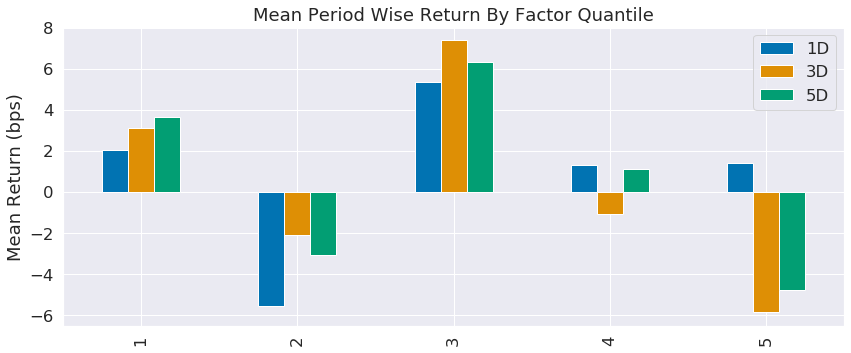

In [36]:
alphalens.tears.create_summary_tear_sheet(factor_data)

Returns Analysis


,1D,3D,5D
Ann. alpha,0.106,-0.038,-0.046
beta,0.030,0.033,0.011
Mean Period Wise Return Top Quantile (bps),1.411,-5.847,-4.757
Mean Period Wise Return Bottom Quantile (bps),2.058,3.141,3.655
Mean Period Wise Spread (bps),-0.647,-9.051,-8.621


<Figure size 432x288 with 0 Axes>

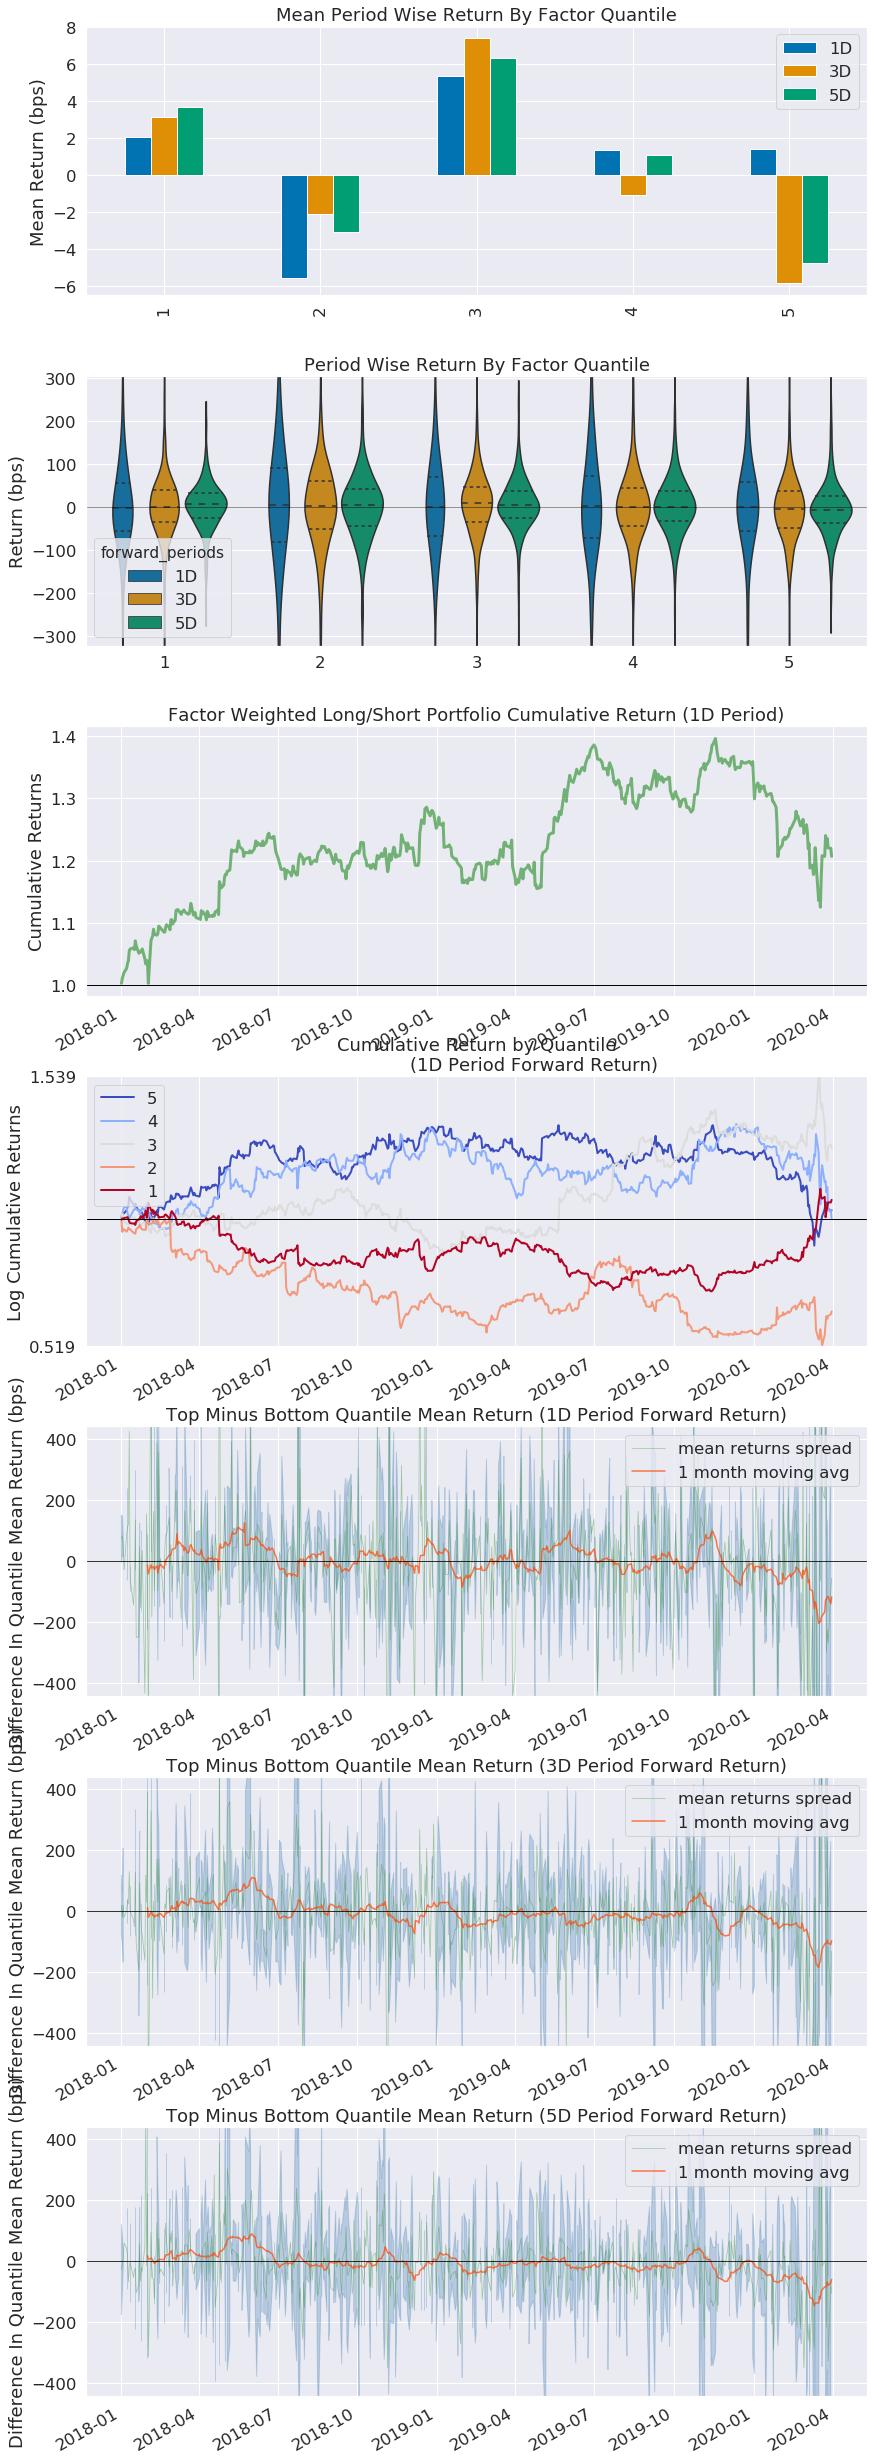

In [37]:
alphalens.tears.create_returns_tear_sheet(factor_data)